<h2>Hadware</h2>

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 882613941096479516
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9274981258479547571
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10029776639326075905
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 75169792
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4283528456030465856
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


<h2> Liberias </h2>

In [2]:
import sys
import os
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.initializers import glorot_uniform
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dropout, Flatten, Dense, Activation,Input,ZeroPadding2D, Add
from tensorflow.python.keras.layers import Convolution2D, MaxPooling2D,BatchNormalization, AveragePooling2D
from tensorflow.python.keras import backend as K

import PIL

from tensorflow.python.keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import datetime


<h3>Definimos las constantes, hiperparametros, etc</h3>

In [7]:
#K.image_data_format() CHANNELS_LAST
nb_train_samples = 7629 
nb_validation_samples = 300


train_dir = 'data/train'
dev_dir = 'data/dev'
test_dir = ' data/test'
epochs = 4
width, height = 306, 306
batch_size = 16
steps = nb_train_samples // batch_size
validation_steps = nb_validation_samples // batch_size
 

<h2>Data augmentation</h2>

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.2,0.8],
    rotation_range=20,
)
    

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(width, height),
    batch_size=batch_size,
    class_mode='categorical')
    
validation_generator = test_datagen.flow_from_directory(
    dev_dir,
    target_size=(width, height),
    batch_size=batch_size,
    class_mode='categorical')
    
 

Found 7629 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


<h1>ResnetModel</h1>

In [3]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Convolution2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Convolution2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Convolution2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    ### END CODE HERE ###

    return X

In [4]:
def convolutional_block(X, f, filters, stage, block, s=2):
    """
    Implementation of the convolutional block as defined in Figure 4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Convolution2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Convolution2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Convolution2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Convolution2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    ### END CODE HERE ###
    return X

In [5]:
def ResNet50(input_shape=(306, 306, 3), classes=3):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Convolution2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [8]:
input_shape = (width, height,3)
model = ResNet50(input_shape=input_shape, classes=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','mean_squared_error'])

ResourceExhaustedError: OOM when allocating tensor with shape[3,3,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add] name: res5a_branch2b/kernel/Initializer/random_uniform/

<h2>Entrenamiento del modelo</h2>

Una vez entrenado se guarda el modelo

In [ ]:
#model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(
        train_generator,
        steps_per_epoch=steps,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        use_multiprocessing=True,
        workers = 8
    )
#Una vez que se entrena, el modelo se guardara en el directorio especificado
#dir = 'modelo/'+ str(datetime.datetime.now()) + '/'
#if os.path.exists(dir) == False:
#    os.mkdir(dir)
##os.path.exists(dir)
#model.save(dir + 'modelo.h5')
#model.save_weights(dir  +'weights.h')


<h2>Cargamos el modelo pre entrenado</h2> 


In [5]:
loaded_model= tf.keras.models.load_model('modelo/2020-02-08 02:07:57.605558/modelo.h5')
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

try:
    history = loaded_model.fit_generator(
        train_generator,
        steps_per_epoch=steps,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        use_multiprocessing=True,
        workers = 8
    )
    dir = 'modelo/'+ str(datetime.datetime.now()) + '/'
    if os.path.exists(dir) == False:
        os.mkdir(dir)
    #os.path.exists(dir)
    loaded_model.save(dir + 'modelo.h5')
    loaded_model.save_weights(dir  +'weights.h')
except tf.errors.ResourceExhaustedEsrror as e:
    dir = 'modelo/'+ str(datetime.datetime.now()) + '/'
    if os.path.exists(dir) == False:
        os.mkdir(dir)
    #os.path.exists(dir)
    loaded_model.save(dir + 'modelo.h5')
    loaded_model.save_weights(dir  +'weights.h')


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 476 steps, validate for 18 steps
Epoch 1/4
476/476 [==============================] - 333s 700ms/step - loss: 0.3591 - accuracy: 0.8455 - val_loss: 0.4562 - val_accuracy: 0.8090
Epoch 2/4
476/476 [==============================] - 325s 683ms/step - loss: 0.3396 - accuracy: 0.8576 - val_loss: 0.5014 - val_accuracy: 0.7882
Epoch 3/4
476/476 [==============================] - 326s 686ms/step - loss: 0.3444 - accuracy: 0.8576 - val_loss: 0.4594 - val_accuracy: 0.8299
Epoch 4/4
476/476 [==============================] - 326s 685ms/step - loss: 0.3383 - accuracy: 0.8573 - val_loss: 0.4770 - val_accuracy: 0.8125


In [ ]:
dir = 'modelo/'+ str(datetime.datetime.now()) + '/'
if os.path.exists(dir) == False:
    os.mkdir(dir)
    #os.path.exists(dir)
loaded_model.save(dir + 'modelo.h5')
loaded_model.save_weights(dir  +'weights.h')


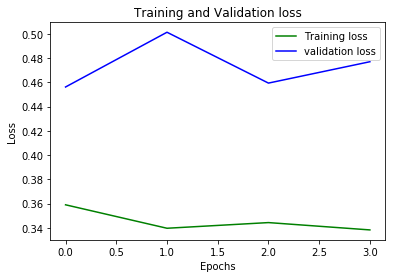

In [28]:
import matplotlib.pyplot as plt
loss_train = history.history['loss']
loss_val = history.history['val_loss']
img = plt.gcf()
plt.plot(range(0,epochs), loss_train, 'g', label='Training loss')
plt.plot(range(0,epochs), loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

img.savefig('resnetPlot/training_lost_last2.png')

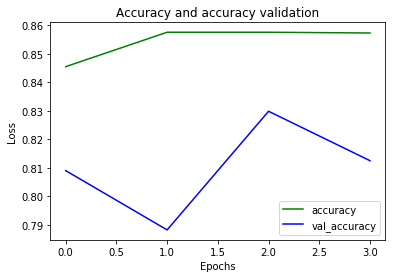

In [27]:
import matplotlib.pyplot as plt
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
img = plt.gcf()
plt.plot(range(0,epochs), loss_train, 'g', label='accuracy')
plt.plot(range(0,epochs), loss_val, 'b', label='val_accuracy')
plt.title('Accuracy and accuracy validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
img.savefig('resnetPlot/accuracy_last2.png')